# Tarea 4 Inteligencia Artificial
## Grupo 15
### Alumnos:

*   Javier Ramos
*   Benjamin Torres

---
###Disclaimer: Las respuestas a las parte 4 y 5 del enunciado estan a lo largo del notebook (el analisis de resultados, las metricas y los hiper-parametros), ademas de que se separaron en 2 modelos, el Modelo I de clasificacion y el Modelo II de prediccion.
----
Se importan Librerias y dependencias que seran utilizadas en el desarrollo de esta tarea.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import seaborn as sns

sns.set_palette('husl')

from pathlib import Path
from time import perf_counter
from google.colab import files
from google.colab import output
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, GlobalAveragePooling2D
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Modelo I:


##Parte 1: Carga de Datos

A continuacion se debe cargar el dataset.

(se puede descargar desde el siguiente link: https://www.kaggle.com/datasets/jeffheaton/iris-computer-vision ).

Debera meter las 3 carpetas del zip descargado en una sola carpeta llamada **iris-computer-vision** y luego comprimirlo a un .zip.

Ademas se debe cambiar el nombre del archivo zip a "DatasetT4IA.zip", notar que debe mantener el formato zip ya que sera descomprimido por el mismo codigo del colab.

In [ ]:
uploaded = files.upload()

Saving DatasetT4IA.zip to DatasetT4IA.zip


In [ ]:
##Se descomprime el dataset en el Google Colab

!unzip -uq DatasetT4IA.zip

In [ ]:
##Se cargan los datos en un generador, se crea un iterator para acceder al generador

data = tf.keras.utils.image_dataset_from_directory('iris-computer-vision')
data_iterator = data.as_numpy_iterator()

Found 421 files belonging to 3 classes.


El siguiente cuadro de codigo se puede correr multiples veces para cambiar el lote de imagenes que se accede

In [ ]:
##Se crea una variable para acceder al generador por lotes

batch = data_iterator.next()

##Volver a correr para cambiar el lote

In [ ]:
##Representa las imagenes como arrays de numpy

batch[0].shape

(32, 256, 256, 3)

A continuacion se imprime el tag de un lote de imagenes (el cual puede ser cambiado como se menciona anteriormente), donde se ve que existen 3 tags, los cuales ya fueron identificados.

In [ ]:
##Class 0 = Iris Setosa
##Class 1 = Iris Versicolour
##Class 2 = Iris Virginica

batch[1]

array([1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 2, 1,
       0, 1, 1, 2, 1, 1, 1, 1, 1, 1], dtype=int32)

Aqui podemos ver que index corresponde a que clase

In [ ]:
class_names = data.class_names
print(class_names)

['iris-setosa', 'iris-versicolour', 'iris-virginica']


El siguiente cuadro muestra las imagenes con sus tags, esto fue utilizado para ver cual tag corresponde a que tipo de iris.

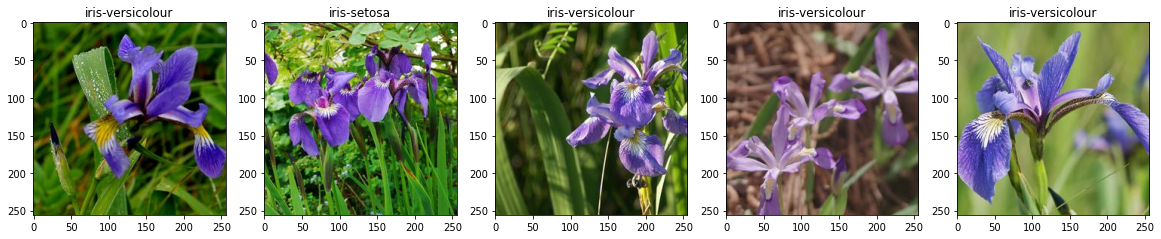

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(class_names[batch[1][idx]])

##Parte 2: Pre-procesamiento de los datos

Se dividen los valores int de las imagenes en 255 cosa de obtener valores entre 0 y 1, lo que seria una normalizacion de los datos, esto no modifica la imagen como se puede ver luego.

In [ ]:
data = data.map(lambda x,y: (x/255,y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next()

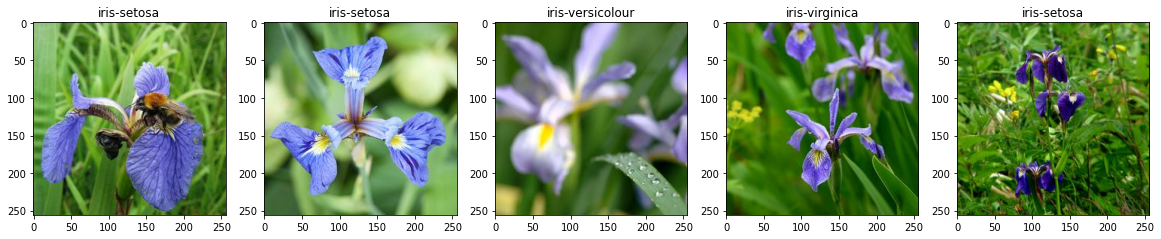

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(class_names[batch[1][idx]])

Se procede a dividir los datos en entrenamiento, validacion y testeo en la proporciones 70%, 20% y 10% respectivamente:

In [ ]:
##Se le suma 1 a los valores de validacion y testeo para que el total sume la cantidad de lotes

train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

if(len(data)==(train_size+val_size+test_size)): print(f"El lote de training es de {train_size}, el de validacion es de {val_size} y el de testeo de {test_size}")

El lote de training es de 9, el de validacion es de 3 y el de testeo de 2


In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

##Parte 3: El Modelo
-------
####Idealmente correr el codigo desde la parte 3.1 a la 5 con el modo GPU de Colab, esto dado que aqui se entrena a la red neuronal y esto toma su buen tiempo, en la parte 5 se permite subir la red ya entrenada y se otorgan los ejemplos para probarla.
-------

###3.1 - Construccion del Modelo:

Se importan a continuacion los tipos de capas que se utilizaran, donde:


*   **Conv2D**: Corresponde a una capa de convolucion espacial en 2D
*   **MaxPooling2D**: Corresponde a una capa de Pooling que condensa y retorna el valor maximo de una region
*   **Dense**: Corresponde a una FCL disponible en keras y nos permite recibir un solo output
*   **Flatten**: Nos permite procesar los datos que pasaron por *Conv2D* y que *Dense* sea capaz de procesarlos

Ademas se importa el modelo que tendra nuestra CNN el cual corresponde a un modelo Secuencial que sirve para cuando se tiene solo un input y un output, ademas de que el flujo por las capas tiene una forma "*Secuencial*"


In [ ]:
model = Sequential()

In [ ]:
##Conv2D(numero de filtros, (x,y cantidad de pixeles), cantidad de pasos en pixeles, funcion de activacion, como se ve el input)

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) ##Convolucion
model.add(MaxPooling2D())                                                   ##Pooling

model.add(Conv2D(32, (3,3), 1, activation='relu'))                          ##Convolucion
model.add(MaxPooling2D())                                                   ##Pooling

model.add(Conv2D(16, (3,3), 1, activation='relu'))                          ##Convolucion
model.add(MaxPooling2D())                                                   ##Pooling

model.add(Flatten())                                                        ##Se aplanan los valores

model.add(Dense(256, activation='relu'))                                    ##FCL 256 capas con activacion relu
model.add(Dense(3, activation='softmax'))                                   ##FCL 3 capas con activacion softmax

In [ ]:
## (optimizador, perdida, metrica que se quiere medir)

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy','mse','mae','msle'])

keras.utils.plot_model(model, "architecture_1.png", show_shapes=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

###3.2 - Entrenamiento:


In [ ]:
!mkdir logs
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

A continuacion se entrena la red con 300 epochs, como se podra ver a continuacion, no hay presencia de overfitting, y mientras mayor sea la sesion de entremamiento, mejores resultados retornara la red, por esto se fue probando con valores de epoch ascendentes.

In [ ]:
##epoch = cuanto tiempo se entrena, 1 epoch es un ciclo de los datos de entrenamiento

hist = model.fit(train, epochs=300, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/300
9/9 [==============================] - 2s 125ms/step - loss: 1.4442 - accuracy: 0.4444 - mse: 1.0032 - mae: 0.8472 - msle: 0.3154 - val_loss: 0.8379 - val_accuracy: 0.6771 - val_mse: 0.9519 - val_mae: 0.8229 - val_msle: 0.3146
Epoch 2/300
9/9 [==============================] - 1s 128ms/step - loss: 0.9165 - accuracy: 0.6424 - mse: 0.8658 - mae: 0.7928 - msle: 0.2760 - val_loss: 0.8718 - val_accuracy: 0.6354 - val_mse: 0.9123 - val_mae: 0.8229 - val_msle: 0.2787
Epoch 3/300
9/9 [==============================] - 1s 125ms/step - loss: 0.8790 - accuracy: 0.6493 - mse: 0.9047 - mae: 0.8137 - msle: 0.2847 - val_loss: 0.8507 - val_accuracy: 0.6667 - val_mse: 0.9142 - val_mae: 0.8299 - val_msle: 0.2772
Epoch 4/300
9/9 [==============================] - 1s 95ms/step - loss: 0.8037 - accuracy: 0.6701 - mse: 0.9006 - mae: 0.8044 - msle: 0.2937 - val_loss: 0.7619 - val_accuracy: 0.6875 - val_mse: 0.9011 - val_mae: 0.8264 - val_msle: 0.2777
Epoch 5/300
9/9 [============================

###3.3 - Graficar Desempeño:

En este caso el gráfico de pérdida es medido con Sparse Categorical Crossentropy, el que resulta eficiente a la hora de evaluar modelos de clasificación.

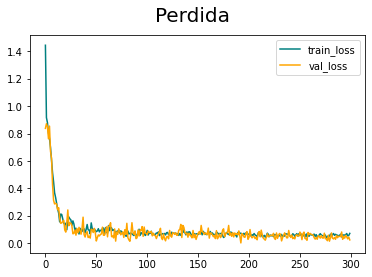

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='train_loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Perdida', fontsize=20)
plt.legend(loc="upper right")
plt.show()

Con el gráfico de pérdida se ve una mejora notoria en el modelo a medida que ocurren los epoch, train_loss y val_loss eventualmente se estabilizan y no divergen, esto quiere decir que no hay overfitting en el modelo y que dicha medida probablemente no pueda mejorar al estar tan cercana a 0.

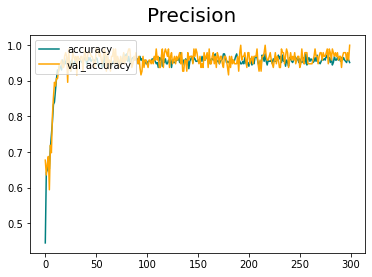

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Precision', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Nuevamente con el gráfico de Precisión podemos reafirmar lo encontrado con el gráfico de Pérdida, el modelo logra aprender de manera estable hasta llegar a un valor muy cercano a 1 y podemos decir que efectivamente aprende, dado que no se aprecia overfitting y posteriormente con los ejemplos quedara demostrado empiricamente.

##Parte 4: Evaluar el desempeño

###4.1 - Grafico MSE y MAE:

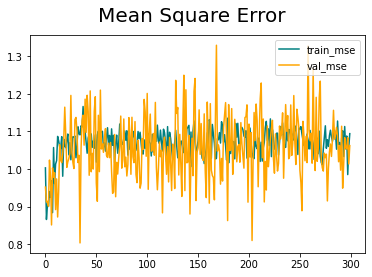

In [ ]:
fig = plt.figure()
plt.plot(hist.history['mse'], color='teal', label='train_mse')
plt.plot(hist.history['val_mse'], color='orange', label='val_mse')
fig.suptitle('Mean Square Error', fontsize=20)
plt.legend(loc="upper right")
plt.show()

En este caso MSE se muestra inestable por ser un modelo de categorización, es decir los valores que puede entregar el modelo son 0, 1 ó 2. Esta es la causa de un gráfico tan disperso, ya que MSE castigará los errores mayores.

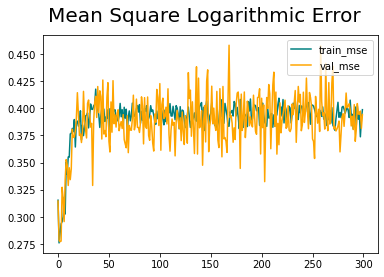

In [ ]:
fig = plt.figure()
plt.plot(hist.history['msle'], color='teal', label='train_mse')
plt.plot(hist.history['val_msle'], color='orange', label='val_mse')
fig.suptitle('Mean Square Logarithmic Error', fontsize=20)
plt.legend(loc="upper right")
plt.show()

MSLE al contrario de MSE castigará más a los errores pequeños, de igual forma las diferencias seguirán siendo entre 0, 1 ó 2. Por lo que el error no logra establizarse.

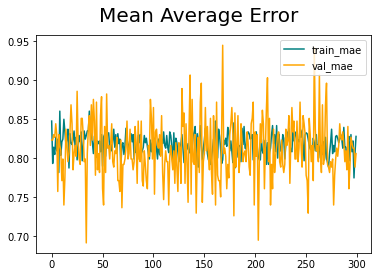

In [ ]:
fig = plt.figure()
plt.plot(hist.history['mae'], color='teal', label='train_mae')
plt.plot(hist.history['val_mae'], color='orange', label='val_mae')
fig.suptitle('Mean Average Error', fontsize=20)
plt.legend(loc="upper right")
plt.show()

MAE castiga valores grandes y chicos por igual, nuevamente por tratarse de un modelo de clasificación no resulta muy efectivo a la hora de evaluar el modelo.

###4.2 - Pruebas:

####- Se prueba primero con el batch de testing:

In [ ]:
real = []
prediction = []
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    for i in y:
      real.append(i)
    for i in yhat:
      prediction.append(np.argmax(i))

1/1 [==============================] - 0s 17ms/step


In [ ]:
r2 = r2_score(real, prediction)
print(f"El R^2 es: {round(r2,2)}")

El R^2 es: 0.93


Este valor de $R^2$ nos dice que el modelo esta bien ajustado, dado que resulta de la comparacion de los calculos reales vs los predichos

In [ ]:
success = 0
for index in range(len(real)):
  if real[index] == prediction[index]: success+=1

print(f"Precision de la predicion: {round(100 * success/len(real),2)}%")

Precision de la predicion: 97.3%


Ademas se puede observar que el % de prediccion exitosa es bastante alto, casi cercano al 100%

#### 4.2.1 - Se prueba ahora con imagenes que no estan en el dataset:
(Esto se comprobo al buscar cada imagen)

Ejemplos de Imagenes:


*   Iris Setosa: https://upload.wikimedia.org/wikipedia/commons/a/a7/Irissetosa1.jpg
*   Iris Versicolor: https://upload.wikimedia.org/wikipedia/commons/2/27/Blue_Flag%2C_Ottawa.jpg
*   Iris Virginica: https://bugwoodcloud.org/images/768x512/1391037.jpg

Descargar las imagenes como archivo JPG y luego subir cada una con los nombres "test_setosa", "test_virginica" y "test_versicolor" segun corresponda.

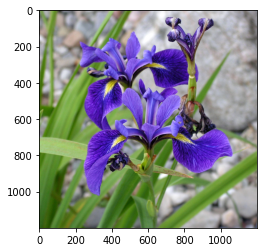

In [ ]:
img = cv2.imread('test_versicolor.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resize/255, 0))
print(f"La flor corresponde a una: {class_names[np.argmax(yhat)]}")

1/1 [==============================] - 0s 17ms/step
La flor corresponde a una: iris-versicolour


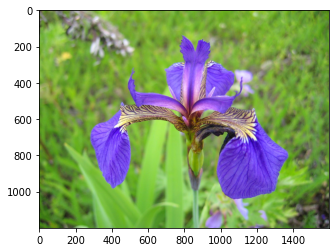

In [ ]:
img2 = cv2.imread('test_setosa.jpg')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize2 = tf.image.resize(img2, (256,256))
yhat2 = model.predict(np.expand_dims(resize2/255, 0))
print(f"La flor corresponde a una: {class_names[np.argmax(yhat2)]}")

1/1 [==============================] - 0s 19ms/step
La flor corresponde a una: iris-setosa


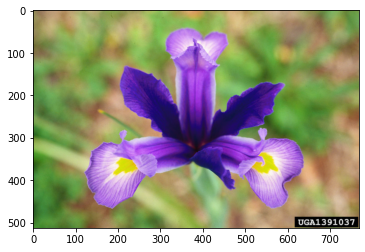

In [ ]:
img3 = cv2.imread('test_virginica.jpg')
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize3 = tf.image.resize(img3, (256,256))
yhat3 = model.predict(np.expand_dims(resize3/255, 0))
print(f"La flor corresponde a una: {class_names[np.argmax(yhat3)]}")

1/1 [==============================] - 0s 18ms/step
La flor corresponde a una: iris-virginica


Se puede ver que la Red logra categorizar de manera correcta las 3 imagenes.

##Parte 5: Carga del modelo entrenado
###5.1 - Guardando el Modelo:

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

Descargar el modelo desde el siguiente link: https://drive.google.com/drive/folders/1ipV6oElGsjNUc-tBtRSJvPV3bkdQmRhL?usp=share_link

###5.2 - Carga del modelo:

Se debe subir el archivo " **imageclassifier.h5** " en una carpeta " models " al colab.

In [ ]:
new_model = load_model('./models/imageclassifier.h5')

Descargar y subir las imagenes de la seccion de pruebas con los nombres "test_setosa", "test_virginica" y "test_versicolor" segun corresponda.

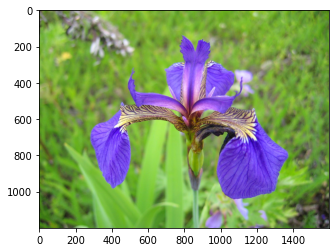

1/1 [==============================] - 0s 17ms/step
La flor corresponde a una: iris-setosa


In [ ]:
img_load = cv2.imread('test_setosa.jpg')
resize = tf.image.resize(img_load, (256,256))
plt.imshow(cv2.cvtColor(img_load, cv2.COLOR_BGR2RGB))
plt.show()
prediction = new_model.predict(np.expand_dims(resize/255, 0))
print(f"La flor corresponde a una: {class_names[np.argmax(prediction)]}")

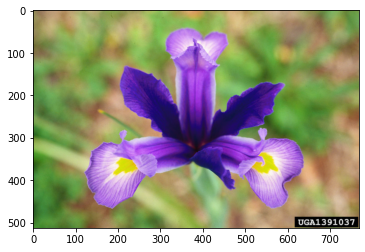

1/1 [==============================] - 0s 17ms/step
La flor corresponde a una: iris-virginica


In [ ]:
img_load = cv2.imread('test_virginica.jpg')
resize = tf.image.resize(img_load, (256,256))
plt.imshow(cv2.cvtColor(img_load, cv2.COLOR_BGR2RGB))
plt.show()
prediction = new_model.predict(np.expand_dims(resize/255, 0))
print(f"La flor corresponde a una: {class_names[np.argmax(prediction)]}")

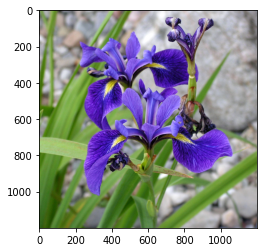

1/1 [==============================] - 0s 16ms/step
La flor corresponde a una: iris-versicolour


In [ ]:
img_load = cv2.imread('test_versicolor.jpg')
resize = tf.image.resize(img_load, (256,256))
plt.imshow(cv2.cvtColor(img_load, cv2.COLOR_BGR2RGB))
plt.show()
prediction = new_model.predict(np.expand_dims(resize/255, 0))
print(f"La flor corresponde a una: {class_names[np.argmax(prediction)]}")

#Modelo II:

##Parte 1: Carga de Datos

A continuacion se deben cargar ambos dataset: el que se uso para el primer modelo (de ser necesario se puede subir en el cuadro con la variable 'uploaded_pics') y el archivo 'Iris.csv'

(El 'Iris.csv' se puede descargar desde el siguiente link: https://www.kaggle.com/datasets/saurabh00007/iriscsv)

In [ ]:
##Cuadro para re-subir el dataset de fotos de ser necesario.

uploaded_pics = files.upload()
!unzip -uq DatasetT4IA.zip

Saving DatasetT4IA.zip to DatasetT4IA.zip


In [ ]:
#Aqui se debe subir el dataset Iris.csv

uploaded_csv = files.upload()

Saving Iris.csv to Iris.csv


##Parte 2: Pre-procesamiento de los datos
Debido a que en esta segunda parte se busca predecir en base a una foto, se requiere mucho mas trabajo previo con los datasets, es mas, a continuacion se procede a operar con ambos datasets, mas especificamente, se busca asociar a cada fila un 'path' de la foto de una flor correspondiente a su especie.

In [ ]:
data_dir = Path('iris-computer-vision') #Carpeta en que están las imágenes
newFile = open('wholeData.csv','w')     #Nuevo csv donde se guardarán las imágenes y sus parámetros respectivos
appendData = open('Iris.csv','r')       #Csv de donde se obtendrán todos los parámetros
columns = appendData.readline().strip().split(',') #obtenemos las columnas originales, leyendo la primera linea
columns.append('ImagePath') #asociamos una nueva columna que tendrá el path de cada imagen
columns = (',').join(columns) #juntamos los nombres de las columnas
newFile.write(columns+"\n") #escribimos la primera linea

75

In [ ]:
#Asociamos las primeras 50 imagenes de cada carpeta a una linea del csv que tenga la misma especie. Haciendo las 150 lineas.

for i in range(150):
  line = appendData.readline().strip().split(',')                     #readline para cada linea del csv
  i_class = line[-1].lower()                                          #obtenemos el tipo de flor en la linea de csv
  if i_class.lower()=='iris-versicolor':                              #if porque en el csv aparece como versicolor y en las clases de imagenes como versicolOUr.
    i_class='iris-versicolour'
  image_name = os.listdir(os.path.join(data_dir, i_class))[i%50]      #obtenemos el nombre de la imagen que pertenece a la carpeta iris-computer-vision/i_class/ en el indice de 0 a 49
  line.append(str(os.path.join(data_dir, i_class,image_name)))        #agregamos el path completo de la imagen tipo 'iris-computer-vision/i_class/image_name.jpg'
  new_line = (',').join(line)                                         #juntamos los datos para agregar a un nuevo csv
  newFile.write(new_line+"\n")                                        #escribimos en el nuevo csv.
newFile.close()

Obtenemos el dataframe con el que se trabajará el modelo.

In [ ]:
#La variable df contiene el nuevo dataset creado que es una mezcla de ambos

df = pd.read_csv('wholeData.csv')
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,ImagePath
0,1,5.1,3.5,1.4,0.2,Iris-setosa,iris-computer-vision/iris-setosa/iris-911f2ca0...
1,2,4.9,3.0,1.4,0.2,Iris-setosa,iris-computer-vision/iris-setosa/iris-5bebf00f...
2,3,4.7,3.2,1.3,0.2,Iris-setosa,iris-computer-vision/iris-setosa/iris-a6b85bf1...
3,4,4.6,3.1,1.5,0.2,Iris-setosa,iris-computer-vision/iris-setosa/iris-20f5f654...
4,5,5.0,3.6,1.4,0.2,Iris-setosa,iris-computer-vision/iris-setosa/iris-9fb8d691...
...,...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica,iris-computer-vision/iris-virginica/iris-4c5d9...
146,147,6.3,2.5,5.0,1.9,Iris-virginica,iris-computer-vision/iris-virginica/iris-6e49e...
147,148,6.5,3.0,5.2,2.0,Iris-virginica,iris-computer-vision/iris-virginica/iris-d99d5...
148,149,6.2,3.4,5.4,2.3,Iris-virginica,iris-computer-vision/iris-virginica/iris-9a37a...


###2.1 - Normalizacion de los datos:

Con el fin de mejorar el cálculo de predicciones, se normalizan los parámetros.



In [ ]:
dataset = pd.read_csv('Iris.csv')
dataset = dataset.drop('Id',axis=1)
dataset = dataset.drop('Species',axis=1)
df_min_max_scaled = df.copy()
for i in dataset.columns:
  df_min_max_scaled[i] = (df_min_max_scaled[i] - df_min_max_scaled[i].min()) / (df_min_max_scaled[i].max() - df_min_max_scaled[i].min())

df = df_min_max_scaled


In [ ]:
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,ImagePath
0,1,0.222222,0.625000,0.067797,0.041667,Iris-setosa,iris-computer-vision/iris-setosa/iris-911f2ca0...
1,2,0.166667,0.416667,0.067797,0.041667,Iris-setosa,iris-computer-vision/iris-setosa/iris-5bebf00f...
2,3,0.111111,0.500000,0.050847,0.041667,Iris-setosa,iris-computer-vision/iris-setosa/iris-a6b85bf1...
3,4,0.083333,0.458333,0.084746,0.041667,Iris-setosa,iris-computer-vision/iris-setosa/iris-20f5f654...
4,5,0.194444,0.666667,0.067797,0.041667,Iris-setosa,iris-computer-vision/iris-setosa/iris-9fb8d691...
...,...,...,...,...,...,...,...
145,146,0.666667,0.416667,0.711864,0.916667,Iris-virginica,iris-computer-vision/iris-virginica/iris-4c5d9...
146,147,0.555556,0.208333,0.677966,0.750000,Iris-virginica,iris-computer-vision/iris-virginica/iris-6e49e...
147,148,0.611111,0.416667,0.711864,0.791667,Iris-virginica,iris-computer-vision/iris-virginica/iris-d99d5...
148,149,0.527778,0.583333,0.745763,0.916667,Iris-virginica,iris-computer-vision/iris-virginica/iris-9a37a...


Dividimos el dataframe en conjuntos disjuntos a razón de (70% + 20%) de training, validación, y 10% de testing. Originalmente train_df tendrá un 90% y será luego dividido en 70% y 20%.

In [ ]:
total_images = 150
image_df = df.sample(total_images, random_state=1).reset_index(drop=True) #random_state = 1 para que los valores tomados del dataframe sean aleatorios
train_df, test_df = train_test_split(image_df, train_size=0.9, test_size = 0.1,  shuffle=True, random_state=1)

Se usan los módulos de ImageDataGenerator de Keras para generar lotes de tensores de información de imágenes. Con validation_split=0.223 quedan entonces 105 imágenes para training, 30 para validation, además 15 quedan para testeo.

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.223
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

Con los tensores creados anteriormente se asocian los dataframe de testeo y training.

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',
    y_col=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'],
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=16,
    shuffle=True,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',
    y_col=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'],
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=16,
    shuffle=True,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',
    y_col=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'],
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=16,
    shuffle=False
)

Found 105 validated image filenames.
Found 30 validated image filenames.
Found 15 validated image filenames.


##Parte 3: El Modelo
Se utilizarán las mismas layers que para el modelo anterior y además la siguiente:
*   **GlobalAveragePooling2D**: Realiza un downsampling utilizando el promedio de dimensiones de altura y ancho del input.

###3.1 Construcción del Modelo

Se aplican los siguientes layers:

In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 3)) #input de imagenes 256x256, 3 por los canales R, G y B

x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs) #Convolución
x = tf.keras.layers.MaxPool2D()(x)                                                    #Pooling

x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)      #Convolución
x = tf.keras.layers.MaxPool2D()(x)                                                    #Pooling

x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(x)      #Convolución
x = tf.keras.layers.MaxPool2D()(x)                                                    #Pooling

x = tf.keras.layers.GlobalAveragePooling2D()(x)                                       #Pooling
x = tf.keras.layers.Flatten()(x)                                                      #Flatten

x = tf.keras.layers.Dense(128, activation='relu')(x)                                  #FCL de 128 capas
x = tf.keras.layers.Dense(64, activation='relu')(x)                                   #FCL de 64 capas

outputs = tf.keras.layers.Dense(4, activation='linear')(x)                            #Output
model2 = tf.keras.Model(inputs=inputs, outputs=outputs)                               #Modelo final (No sequential, porque se trata de más de un parámetro.)

A continuación se guardan los logs, se usa MSE como métrica de loss. Adam como optimizer.

In [ ]:
logdir='logs2'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
model2.compile(optimizer='adam', loss='mse' ,metrics=['accuracy','msle','mae'])

keras.utils.plot_model(model2, "architecture_2.png", show_shapes=True)
model2.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624  

###3.2 Entrenamiento:

Se entrena el modelo con el tensor train_images, validación con val_images y epoch 50, este último se dejo en 50 porque realizando un análisis de los gráficos de pérdida con un numero mayor de epochs (100), se observó que las curvas de train_loss y val_loss divergían cerca del 50, lo cual significa que cerca de ese valor comienza a ocurrir overfitting.

In [ ]:
history = model2.fit(train_images,validation_data=val_images,epochs=50,callbacks=[tensorboard_callback])

Epoch 1/50
7/7 [==============================] - 10s 143ms/step - loss: 0.2259 - accuracy: 0.3143 - msle: 0.1272 - mae: 0.4033 - val_loss: 0.1480 - val_accuracy: 0.4000 - val_msle: 0.0766 - val_mae: 0.3232
Epoch 2/50
7/7 [==============================] - 0s 53ms/step - loss: 0.1204 - accuracy: 0.3143 - msle: 0.0614 - mae: 0.2898 - val_loss: 0.1106 - val_accuracy: 0.4000 - val_msle: 0.0560 - val_mae: 0.2604
Epoch 3/50
7/7 [==============================] - 0s 52ms/step - loss: 0.0877 - accuracy: 0.2762 - msle: 0.0446 - mae: 0.2453 - val_loss: 0.0863 - val_accuracy: 0.3333 - val_msle: 0.0429 - val_mae: 0.2405
Epoch 4/50
7/7 [==============================] - 0s 54ms/step - loss: 0.0820 - accuracy: 0.1810 - msle: 0.0403 - mae: 0.2448 - val_loss: 0.0868 - val_accuracy: 0.2000 - val_msle: 0.0436 - val_mae: 0.2414
Epoch 5/50
7/7 [==============================] - 0s 52ms/step - loss: 0.0776 - accuracy: 0.3333 - msle: 0.0391 - mae: 0.2390 - val_loss: 0.0891 - val_accuracy: 0.3333 - val_msle

### 3.3. Graficar Desempeño:

Se predicen parámetros en función de las imágenes.

In [ ]:
predicted_parameters = model2.predict(test_images)
predicted_parameters

1/1 [==============================] - 0s 277ms/step


array([[0.2817886 , 0.46882308, 0.25515968, 0.2505046 ],
       [0.5374934 , 0.3478204 , 0.6290664 , 0.62599987],
       [0.5659176 , 0.3686373 , 0.6462772 , 0.6411832 ],
       [0.4026688 , 0.5156481 , 0.38625705, 0.39661157],
       [0.6430579 , 0.41838726, 0.72828996, 0.72031474],
       [0.6537479 , 0.3953945 , 0.7341447 , 0.7337186 ],
       [0.5508864 , 0.3989936 , 0.6331824 , 0.62299955],
       [0.44256955, 0.40383792, 0.505037  , 0.49672973],
       [0.52511615, 0.3969716 , 0.5938324 , 0.58517915],
       [0.29978102, 0.46089166, 0.27867877, 0.28152174],
       [0.356082  , 0.45441717, 0.37169752, 0.37030593],
       [0.5224982 , 0.35967416, 0.609751  , 0.60204154],
       [0.2705128 , 0.51084155, 0.23678923, 0.22007716],
       [0.21827245, 0.45737597, 0.17411894, 0.15654501],
       [0.52545756, 0.39569348, 0.60696864, 0.6017898 ]], dtype=float32)

Se ven los parámetros reales asociados a las imágenes.

In [ ]:
true_parameters = test_images.labels
true_parameters

array([[0.47222222, 0.375     , 0.59322034, 0.58333333],
       [0.80555556, 0.66666667, 0.86440678, 1.        ],
       [0.58333333, 0.375     , 0.55932203, 0.5       ],
       [0.41666667, 0.25      , 0.50847458, 0.45833333],
       [0.44444444, 0.41666667, 0.54237288, 0.58333333],
       [0.52777778, 0.33333333, 0.6440678 , 0.70833333],
       [0.5       , 0.25      , 0.77966102, 0.54166667],
       [0.63888889, 0.375     , 0.61016949, 0.5       ],
       [0.55555556, 0.20833333, 0.6779661 , 0.75      ],
       [0.08333333, 0.5       , 0.06779661, 0.04166667],
       [0.91666667, 0.41666667, 0.94915254, 0.83333333],
       [0.55555556, 0.54166667, 0.62711864, 0.625     ],
       [0.05555556, 0.125     , 0.05084746, 0.08333333],
       [0.33333333, 0.625     , 0.05084746, 0.04166667],
       [0.55555556, 0.54166667, 0.84745763, 1.        ]])

Se calcula el valor de R^2.

In [ ]:
#rmse = np.sqrt(model2.evaluate(test_images, verbose=0))
r2 = r2_score(true_parameters, predicted_parameters)

#print(f"     Test RMSE: {rmse}")
print("Test R^2 Score: {:.5f}".format(r2))

1/1 [==============================] - 0s 59ms/step
Test R^2 Score: 0.11002


El valor de R^2 anterior no es el esperado pero está dentro de los mejores obtenidos a lo largo de varias iteraciones y variaciones de layers dentro del modelo, esto puede deberse a una variedad de causas.

Entre estas puede ser que al asociarse una imágen con una línea de parámetros, estos parámetros no concordaban con los de dicha imagen. Por ejemplo, una linea del dataframe puede decir que la flor tiene PetalWidthCm = 5 pero la imágen en cuestión tiene un ancho de pétalo mucho menor. Hay imágenes dentro del dataset que no muestran solo a una flor, sino un conjunto de ellas, por lo que las dimensiones de cada flor se ven reducidas.

Otra idea que se maneja es que el dataframe solo cuenta con 150 muestras, esto es muy pequeño para lo que se busca predecir.



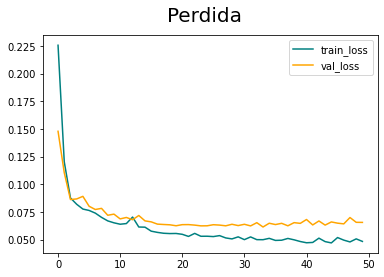

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='train_loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Perdida', fontsize=20)
plt.legend(loc="upper right")
plt.show()

La gráfica anterior muestra la Pérdida a lo largo de los 50 Epoch, que en este caso es medida por MSE. Como se logra notar el train_loss y val_loss comenzaron a diverger, esto es muestra de overfitting, pero en distintas iteraciones con distintos valores de EPOCH, esta divergencia ocurría en distintos puntos.

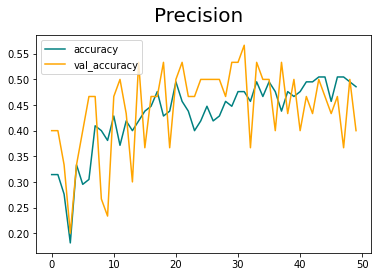

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Precision', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Con la gráfica de Precisión a lo largo de los 50 Epoch, se logra notar una mejora pero esta no es evidente ni estable. En este caso Accuracy y Val_Accuracy debiesen mejorar a la par a lo largo de los Epoch, y esto es logrado, pero para evitar overfitting por el gráfico anterior de pérdida es que se mantiene en 50 epoch.

## Parte 4: Evaluar el Desempeño

###4.1 - Grafico MSE y MAE:

Con el siguiente gráfico de MSLE y el anterior de MSE(Pérdida) se ve que el error se ve reducido para para el set de entrenamiento y el de validación, lo que indica que el modelo efectivamente aprende a lo largo de los epoch.

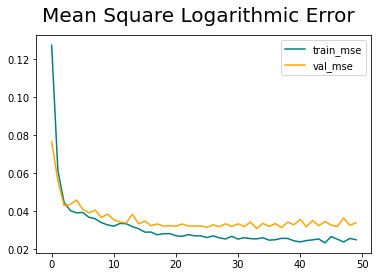

In [ ]:
fig = plt.figure()
plt.plot(history.history['msle'], color='teal', label='train_mse')
plt.plot(history.history['val_msle'], color='orange', label='val_mse')
fig.suptitle('Mean Square Logarithmic Error', fontsize=20)
plt.legend(loc="upper right")
plt.show()

De igual forma con MAE se logra notar que el error disminuye, reafirmando que el error disminuye, pero val_mae comienza a estabilizarse a pesar de que train_mae sigue disminuyendo. En otras palabras, el modelo sigue aprendiendo pero esto no se ve reflejado en el rendimiento en el set de validación.

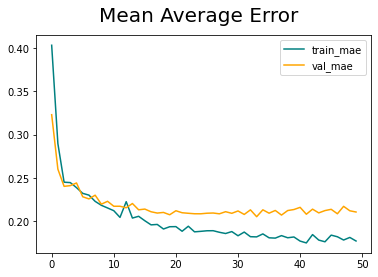

In [ ]:
fig = plt.figure()
plt.plot(history.history['mae'], color='teal', label='train_mae')
plt.plot(history.history['val_mae'], color='orange', label='val_mae')
fig.suptitle('Mean Average Error', fontsize=20)
plt.legend(loc="upper right")
plt.show()

Finalmente podemos notar que el modelo logra predecir hasta cierto punto los parámetros pero no con mucha precisión, esto y debido las distintas ideas que se están considerando como posibles causas de esto es que se evalua a continuación el mismo modelo con la predicción de solo 1 parámetro.

## Parte 5: El modelo con 1 parámetro.

A continuación se testea el mismo modelo con solo un parámetro como output: PetalWidthCm.
Esto para ver como la reducción de parámetros a predecir puede mejorar el rendimiento general del modelo.

In [ ]:
train_images2 = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',
    y_col='PetalWidthCm',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=16,
    shuffle=True,
    subset='training'
)
val_images2 = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',
    y_col='PetalWidthCm',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=16,
    shuffle=True,
    subset='validation'
)
test_images2 = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',
    y_col='PetalWidthCm',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=16,
    shuffle=False
)

Found 105 validated image filenames.
Found 30 validated image filenames.
Found 15 validated image filenames.


Se busca mantener fijos layers aplicados, pero el último layer debe ser Dense 1, ya que en este caso se trata de solo una salida.

In [ ]:
inputs2 = tf.keras.Input(shape=(256, 256, 3))
x2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs2)
x2 = tf.keras.layers.MaxPool2D()(x2)
x2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x2)
x2 = tf.keras.layers.MaxPool2D()(x2)
x2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(x2)
x2 = tf.keras.layers.MaxPool2D()(x2)
x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)
#x2 = tf.keras.layers.Flatten()(x2)
x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
outputs2 = tf.keras.layers.Dense(1, activation='linear')(x2)
model22 = tf.keras.Model(inputs=inputs2, outputs=outputs2)

In [ ]:
logdir2='logs'
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=logdir2)
model22.compile(optimizer='adam', loss='mse' ,metrics=['accuracy','msle','mae'])

keras.utils.plot_model(model22, "architecture_5.png", show_shapes=True)
model22.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_34 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 60, 60, 16)        4624

In [ ]:
history2 = model22.fit(train_images2,validation_data=val_images2,epochs=40,callbacks=[tensorboard_callback2])

Epoch 1/40
7/7 [==============================] - 2s 92ms/step - loss: 0.2320 - accuracy: 0.0476 - msle: 0.1208 - mae: 0.3882 - val_loss: 0.1280 - val_accuracy: 0.0333 - val_msle: 0.0644 - val_mae: 0.3194
Epoch 2/40
7/7 [==============================] - 0s 57ms/step - loss: 0.1365 - accuracy: 0.0190 - msle: 0.0700 - mae: 0.3225 - val_loss: 0.1269 - val_accuracy: 0.0333 - val_msle: 0.0681 - val_mae: 0.3023
Epoch 3/40
7/7 [==============================] - 0s 58ms/step - loss: 0.1269 - accuracy: 0.0476 - msle: 0.0628 - mae: 0.3185 - val_loss: 0.1176 - val_accuracy: 0.0333 - val_msle: 0.0593 - val_mae: 0.3065
Epoch 4/40
7/7 [==============================] - 0s 57ms/step - loss: 0.1260 - accuracy: 0.0476 - msle: 0.0609 - mae: 0.3198 - val_loss: 0.1061 - val_accuracy: 0.0333 - val_msle: 0.0559 - val_mae: 0.2869
Epoch 5/40
7/7 [==============================] - 0s 61ms/step - loss: 0.1121 - accuracy: 0.0476 - msle: 0.0573 - mae: 0.2970 - val_loss: 0.1105 - val_accuracy: 0.0333 - val_msle: 

In [ ]:
predicted_parameters2 = model22.predict(test_images2)
predicted_parameters2

1/1 [==============================] - 0s 109ms/step


array([[0.2406593 ],
       [0.65583247],
       [0.71675724],
       [0.36251858],
       [0.74252754],
       [0.7586964 ],
       [0.6183087 ],
       [0.47490928],
       [0.60354906],
       [0.21888413],
       [0.26330444],
       [0.6248376 ],
       [0.18876313],
       [0.11859331],
       [0.6152116 ]], dtype=float32)

In [ ]:
true_parameters2 = test_images2.labels
true_parameters2

array([0.58333333, 1.        , 0.5       , 0.45833333, 0.58333333,
       0.70833333, 0.54166667, 0.5       , 0.75      , 0.04166667,
       0.83333333, 0.625     , 0.08333333, 0.04166667, 1.        ])

Se calcula R^2 para el nuevo modelo.

In [ ]:
r22 = r2_score(true_parameters2, predicted_parameters2)
print("Test R^2 Score: {:.5f}".format(r22))

Test R^2 Score: 0.33450


Con este nuevo valor de R^2 que es mayor que el anterior, se logra ver que con menor número de outputs el modelo es capaz de mejorar sus predicciones para un parámetro.

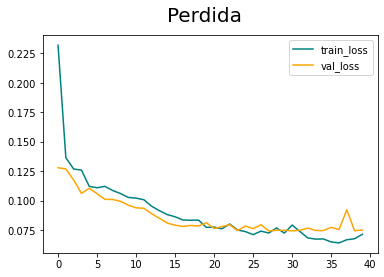

In [ ]:
fig = plt.figure()
plt.plot(history2.history['loss'], color='teal', label='train_loss')
plt.plot(history2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Perdida', fontsize=20)
plt.legend(loc="upper right")
plt.show()

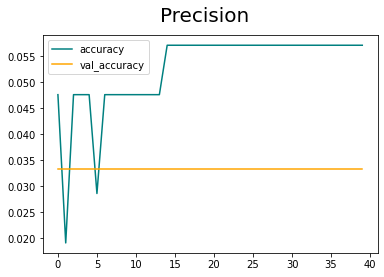

In [ ]:
fig = plt.figure()
plt.plot(history2.history['accuracy'], color='teal', label='accuracy')
plt.plot(history2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Precision', fontsize=20)
plt.legend(loc="upper left")
plt.show()

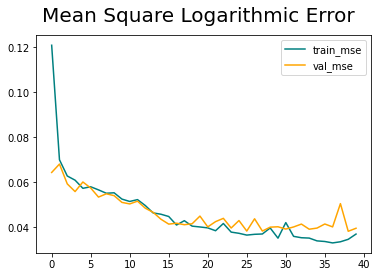

In [ ]:
fig = plt.figure()
plt.plot(history2.history['msle'], color='teal', label='train_mse')
plt.plot(history2.history['val_msle'], color='orange', label='val_mse')
fig.suptitle('Mean Square Logarithmic Error', fontsize=20)
plt.legend(loc="upper right")
plt.show()

El MSLE obtenido muestra que el modelo sigue aprendiendo, pero los MSLE del set de entrenamiento y validación comienzan a diverger luego de los 30 Epoch.

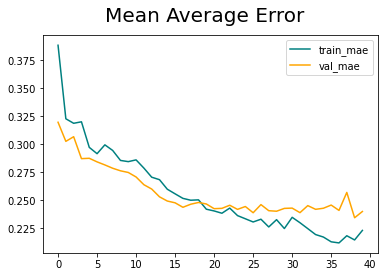

In [ ]:
fig = plt.figure()
plt.plot(history2.history['mae'], color='teal', label='train_mae')
plt.plot(history2.history['val_mae'], color='orange', label='val_mae')
fig.suptitle('Mean Average Error', fontsize=20)
plt.legend(loc="upper right")
plt.show()

Finalmente al igual que con MSLE el MAE muestra una mejora en el modelo, pero a más epoch, menor se vuelve el efecto en el set de validación.